# **Estimating Soil Propeties 3D Models Using Pretrained Weights**

In [1]:
import os

import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm

from sklearn import preprocessing
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

from numpy import ones,vstack
from numpy.linalg import lstsq

In [2]:
DATA_DIR = '/home/daitran/Desktop/git/soil_properties/data'

ntb_data_path = os.path.join(DATA_DIR, 'NTB_black_data_remove_class_5.csv')
tb_data_path = os.path.join(DATA_DIR, '210507 TB (Blue) data_(PDF and CAD).csv')

ntb_data= pd.read_csv(ntb_data_path)
tb_data = pd.read_csv(tb_data_path)

In [3]:
remove_piles = ['TB-21', 'TB-22']

for remove_pile in remove_piles: 
    indexNames = tb_data[(tb_data['Name'] == remove_pile)].index
    tb_data.drop(indexNames , inplace=True)


### **Estimated Area**

### Data pre-processing

In [5]:
# Specific soil types
assign_num_list = {
                    'topsoil layer': 7,
                    'reclaimed layer': 6,
                    'sedimentary layer': 5,
                    'weathered soil': 4,
                    'weathered rock': 3,
                    'soft rock': 2,
                    'moderate rock': 1,
                     'hard rock': 0,
                  }

In [6]:
ntb_names = ntb_data['Soi properties (main)']
tb_names = tb_data['Soi properties (main)']

ntb_target = ntb_names.replace(assign_num_list)
tb_target = tb_names.replace(assign_num_list)

ntb_data['Target'] = ntb_target
tb_data['Target'] = tb_target

X_train_ntb = ntb_data[['X','Y','Elevation']].to_numpy()
y_train_ntb = ntb_data['Target'].to_numpy()

X_train_tb = tb_data[['X1(CAD)','Y1(CAD)','Elevation']].to_numpy()
y_train_tb = tb_data['Target'].to_numpy()

# merge NTB and TB
X_train_merged_ntb_tb = np.concatenate((X_train_ntb, X_train_tb), axis=0)
y_train_merged_ntb_tb = np.concatenate((y_train_ntb, y_train_tb), axis=0)

# https://scikit-learn.org/stable/modules/preprocessing.html
normalizer = preprocessing.MinMaxScaler()

normalizer.fit(X_train_merged_ntb_tb)


normalized_X_train_ntb = normalizer.transform(X_train_ntb)
normalized_X_train_tb = normalizer.transform(X_train_tb)
normalized_X_merged_ntb_tb = np.concatenate((normalized_X_train_ntb, normalized_X_train_tb), axis=0)



# ## Unnormalize
# normalized_X_train_ntb = X_train_ntb
# normalized_X_train_tb = X_train_tb

# X_train_merged_ntb_tb = np.concatenate((X_train_ntb, X_train_tb), axis=0)
# normalized_X_merged_ntb_tb = X_train_merged_ntb_tb
# y_train_merged_ntb_tb = np.concatenate((y_train_ntb, y_train_tb), axis=0)

In [7]:
max_x = 550978
max_y = 213895

min_x = 549653
min_y = 213759

In [8]:
max_z = int(np.max(X_train_merged_ntb_tb[:,2]))
min_z = int(np.min(X_train_merged_ntb_tb[:,2]))

In [9]:
# Full test site
X_TEST_START = min_x
X_TEST_STOP = max_x
X_STEP = 3

Y_TEST_START = min_y
Y_TEST_STOP = max_y
Y_STEP = 3

ELEVATION_START = min_z
ELEVATION_STOP = max_z # change maximum elevation
ELEVATION_STEP = 2

# model_type = 'probabilistic'
model_type = 'deterministic'

In [10]:
min_z

78

In [11]:
max_z

144

# Load Pretrained Weights - *Check regression_models.ipynb file for model architecture*

In [12]:
EPOCHS = 1000
BATCH_SIZES = 16
LR = 0.001

In [13]:
def create_model(dim):
    model = Sequential([
        Dense(128, activation = 'relu', kernel_initializer='he_normal', input_dim = dim),
        Dense(64, activation = 'relu', kernel_initializer='he_normal'),
        Dense(32, activation = 'relu', kernel_initializer='he_normal'),
        Dense(16, activation = 'relu', kernel_initializer='he_normal'),
        Dense(8, activation = 'relu', kernel_initializer='he_normal'),
        Dense(1, kernel_initializer='he_normal', activation='linear')
    ])
    
    model.compile(loss='mean_squared_error',
              optimizer=tf.optimizers.Adam(learning_rate=LR))
    
    model.summary()
    return model

### Get best weights from deterministic or probabilistic model

In [14]:
def get_model_best_epoch(model, model_type, train_data = 'ntb'):
    current_dir = os.getcwd()
    if model_type:
        checkpoint_path = current_dir + "/checkpoints_best_only_{}_{}/checkpoint".format(model_type, train_data)
        print(checkpoint_path)
    model.load_weights(checkpoint_path)
    
    return model

# Create line equation 

In [15]:
# 900
X_900_1 = 549660
Y_900_1 = 213759

X_900_2 = 549653
Y_900_2 = 213828

# 1220
X_1220_1 = 550978
Y_1220_1 = 213825

X_1220_2 = 550974
Y_1220_2 = 213895

In [16]:
tb_1_x = tb_data.loc[tb_data['Name']=='TB-1']['X'][0]
tb_1_y = tb_data.loc[tb_data['Name']=='TB-1']['Y'][0]

In [17]:
tb_20_x = tb_data.loc[tb_data['Name']=='TB-20']['X'][100]
tb_20_y = tb_data.loc[tb_data['Name']=='TB-20']['Y'][100]

In [18]:
Y_1220_1 - Y_900_1

66

In [19]:
def generate_road_points():
    full_test_area = np.empty((0,3), int)
#     for y_step in tqdm(range(Y_900_1, Y_900_2, 60)):
    for k in range(5,65, Y_STEP):
        points = [(X_900_1,Y_900_1 + k ),(X_1220_1,Y_1220_1+ k)]
        x_coords, y_coords = zip(*points)
        A = vstack([x_coords,ones(len(x_coords))]).T
        m, c = lstsq(A, y_coords)[0]
    #         print("Line Solution is y = {m}x + {c}".format(m=m,c=c))

        ## Generate points
        cross_sectional_point = np.empty((0,3), int)
        for x_in_line in tqdm(range(int(X_900_1), int(X_1220_1), X_STEP)):
            y_in_line = m*x_in_line + c
            for elevation in (range(ELEVATION_START, ELEVATION_STOP, ELEVATION_STEP)):
                row = np.array([])
                row = np.array([x_in_line,y_in_line,elevation])
                row = np.expand_dims(row,axis=0)
                cross_sectional_point = np.append(cross_sectional_point, row, axis = 0)
        full_test_area = np.append(full_test_area, cross_sectional_point, axis = 0)

    return full_test_area
full_test_area = generate_road_points()

/home/daitran/miniconda3/envs/probability/lib/python3.7/site-packages/ipykernel_launcher.py:8: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  
100%|██████████| 440/440 [00:00<00:00, 1678.60it/s]


In [20]:
full_test_area.shape

(290400, 3)

In [21]:
normalized_cross_sectional_point = normalizer.transform(full_test_area)

# Create Estimated Data Points

In [22]:
# def test_area_generate():
#     test_area = np.empty((0,3), int)
    
#     for x in tqdm((range(X_TEST_START, X_TEST_STOP,X_STEP))):
#         for y in (range(Y_TEST_START, Y_TEST_STOP,Y_STEP)):
#             for elevation in (range(ELEVATION_START, ELEVATION_STOP, ELEVATION_STEP)):
#                 row = np.array([])
#                 row = np.array([x,y,elevation])
#                 row = np.expand_dims(row,axis=0)
#     #             print(row.shape)
#                 test_area = np.append(test_area, row, axis = 0)
# #             print('Locationx: {}, y: {}, elevation: {}'.format(x,y,elevation))
#     return test_area

In [23]:
# X_test = test_area_generate()

In [24]:
# normalized_X_test = normalizer.transform(X_test)

In [25]:
# np.unique(normalized_X_test)

In [26]:
def estimate_soil_properties(model, normalized_X_test):
    results = []
    for i in tqdm(range(len(normalized_X_test))):
        test_location = normalized_X_test[i]
        test_location = np.expand_dims(test_location, axis =0)
        result = model.predict(test_location)
#         print(result)
        results.append(int(result)-1)
    return np.array(results)

## **Predict test area using model train on NTB**

In [27]:
model = get_model_best_epoch(model = create_model(dim=3), model_type='deterministic', train_data = 'ntb')

KeyboardInterrupt: 

### Predict cross sectional 

In [ ]:
y_cross_sectional_predict = estimate_soil_properties(model = model, normalized_X_test = normalized_cross_sectional_point)

In [ ]:
y_cross_sectional_predict[y_cross_sectional_predict < 0] = 0
y_cross_sectional_predict[y_cross_sectional_predict > 7] = 7

In [ ]:
np.unique(y_cross_sectional_predict)

In [30]:
# y_estimate = estimate_soil_properties(model = model, test_area = normalized_X_test)

In [31]:
# y_estimate[y_estimate < 0] = 0
# y_estimate[y_estimate > 7] = 7

# 3D Estimated Points Visualization

In [28]:
max_x = np.max(X_train_merged_ntb_tb[:,0])
max_y = np.max(X_train_merged_ntb_tb[:,1])

min_x = np.min(X_train_merged_ntb_tb[:,0])
min_y = np.min(X_train_merged_ntb_tb[:,1])

In [29]:
def plot_data(x, y, labels, colours):
    
    sns.set(style = "darkgrid")

    fig = plt.figure(figsize=(20, 10))
    
    ax = fig.add_subplot(121, projection='3d')

    for c in np.unique(y):
        inx = np.where(y == c)
        ax.scatter(x[inx, 0], x[inx, 1], x[inx, 2], label=labels[c], c=colours[c])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Elevation')
        plt.xlim([min_x, max_x])
        plt.ylim([min_y, max_y])
        ax.set_zlim(80, 140)
        
    ax = fig.add_subplot(122, projection='3d')
    for c in np.unique(y):
        inx = np.where(y == c)
        ax.scatter(x[inx, 0], x[inx, 1], x[inx, 2], label=labels[c], c=colours[c])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Elevation')
        ax.view_init(90, 0)   
        plt.xlim([min_x, max_x])
        plt.ylim([min_y, max_y])
        ax.set_zlim(80, 140)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),
          fancybox=True, shadow=True, ncol=5)

In [30]:
labels = {}
for k, v in assign_num_list.items():
    labels[v] = k

In [31]:
label_colours = ['black', 'brown', 'red', 'magenta',
                'pink', 'green',
                'blue','cyan']

# DNN Results

In [36]:
total_data = np.concatenate((full_test_area, X_train_merged_ntb_tb), axis = 0)

In [37]:
total_soil_types = np.concatenate((y_cross_sectional_predict, y_train_merged_ntb_tb), axis = 0)

In [38]:
full_test_area.shape

(290400, 3)

In [39]:
X_train_merged_ntb_tb.shape

(201, 3)

In [40]:
y_cross_sectional_predict.shape

(290400,)

In [41]:
y_train_merged_ntb_tb.shape

(201,)

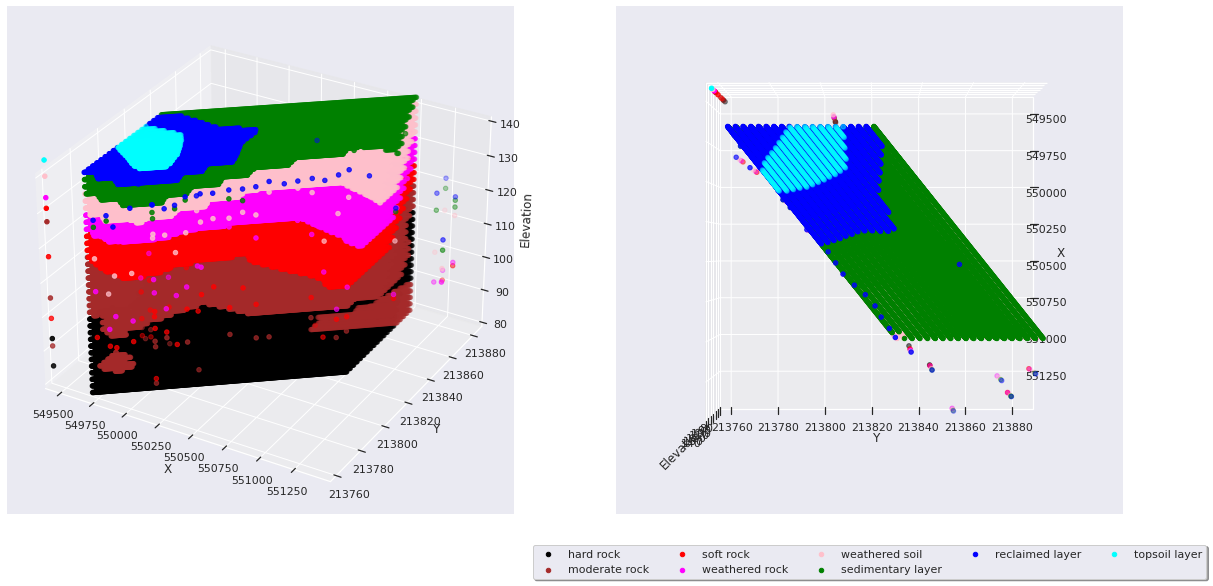

In [42]:
plot_data(total_data, total_soil_types, labels, label_colours)

plt.show()

In [43]:
total_data

array([[5.49660000e+05, 2.13764000e+05, 7.80000000e+01],
       [5.49660000e+05, 2.13764000e+05, 8.00000000e+01],
       [5.49660000e+05, 2.13764000e+05, 8.20000000e+01],
       ...,
       [5.50974139e+05, 2.13829417e+05, 9.48500000e+01],
       [5.50974139e+05, 2.13829417e+05, 9.05500000e+01],
       [5.50974139e+05, 2.13829417e+05, 8.01500000e+01]])

## Generate .csv

In [44]:
data_csv = pd.DataFrame({'X': total_data[:,0],
                        'Y': total_data[:,1],
                        'Elevation': total_data[:,2],
                        'Target': total_soil_types})

In [45]:
data_csv

,X,Y,Elevation,Target
0,549660.0000,213764.0000,78.00,0
1,549660.0000,213764.0000,80.00,0
2,549660.0000,213764.0000,82.00,0
3,549660.0000,213764.0000,84.00,0
4,549660.0000,213764.0000,86.00,0
...,...,...,...,...
290596,550974.1386,213829.4167,129.75,4
290597,550974.1386,213829.4167,103.65,3
290598,550974.1386,213829.4167,94.85,2
290599,550974.1386,213829.4167,90.55,1


In [46]:
data_csv.to_csv(r'/home/daitran/Desktop/git/soil_properties/output_results/export_dataframe_train_on_ntb.csv', index = False)

## **Predict test area using model train on TB**

In [47]:
# model = get_model_best_epoch(model = create_model(dim=3), model_type='deterministic', train_data = 'tb')

In [48]:
# y_estimate = estimate_soil_properties(model = model, test_area = normalized_X_test)

In [49]:
# y_estimate[y_estimate < 0] = 0
# y_estimate[y_estimate > 7] = 7

In [50]:
# plot_data(X_test, y_estimate, labels, label_colours)
# plt.savefig('/home/daitran/Desktop/git/soil_properties/figures/estimated_tb.png')
# plt.show()

In [51]:
# data_csv = pd.DataFrame({'X': X_test[:,0],
#                         'Y': X_test[:,1],
#                         'Elevation': X_test[:,2],
#                         'Target': y_estimate})

In [52]:
# data_csv

In [53]:
# data_csv.to_csv(r'/home/daitran/Desktop/git/soil_properties/output_results/export_dataframe_train_on_tb.csv', index = False)

## **Predict test area using model train on merged NTB and TB**

In [32]:
model = get_model_best_epoch(model = create_model(dim=3), model_type='deterministic', train_data = 'merged_ntb_tb')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               512       
_________________________________________________________________
dense_7 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_10 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 9         
Total params: 11,521
Trainable params: 11,521
Non-trainable params: 0
__________________________________________________

In [33]:
y_cross_sectional_predict = estimate_soil_properties(model = model, normalized_X_test = normalized_cross_sectional_point)

100%|██████████| 290400/290400 [1:19:32<00:00, 60.84it/s]


In [34]:
y_cross_sectional_predict[y_cross_sectional_predict < 0] = 0
y_cross_sectional_predict[y_cross_sectional_predict > 7] = 7

In [35]:
# plot_data(full_test_area, y_cross_sectional_predict, labels, label_colours)

# plt.show()

In [36]:
total_data = np.concatenate((full_test_area, X_train_merged_ntb_tb), axis = 0)
total_soil_types = np.concatenate((y_cross_sectional_predict, y_train_merged_ntb_tb), axis = 0)




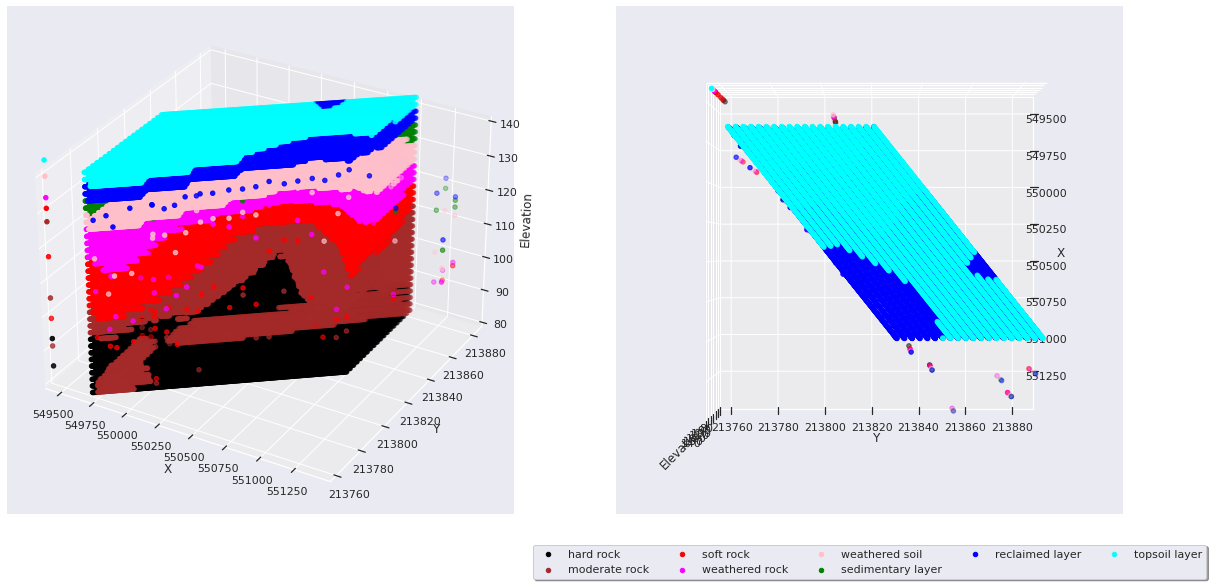

In [37]:
plot_data(total_data, total_soil_types, labels, label_colours)

plt.show()

In [38]:
# y_estimate = estimate_soil_properties(model = model, test_area = normalized_X_test)

In [39]:
# y_estimate[y_estimate < 0] = 0
# y_estimate[y_estimate > 7] = 7

In [40]:
# plot_data(X_test, y_estimate, labels, label_colours)
# plt.savefig('/home/daitran/Desktop/git/soil_properties/figures/estimated_merged_ntb_tb.png')
# plt.show()

In [41]:
data_csv = pd.DataFrame({'X': total_data[:,0],
                        'Y': total_data[:,1],
                        'Elevation': total_data[:,2],
                        'Target': total_soil_types})

In [42]:
data_csv

,X,Y,Elevation,Target
0,549660.0000,213764.0000,78.00,0
1,549660.0000,213764.0000,80.00,0
2,549660.0000,213764.0000,82.00,0
3,549660.0000,213764.0000,84.00,0
4,549660.0000,213764.0000,86.00,0
...,...,...,...,...
290596,550974.1386,213829.4167,129.75,4
290597,550974.1386,213829.4167,103.65,3
290598,550974.1386,213829.4167,94.85,2
290599,550974.1386,213829.4167,90.55,1


In [43]:
data_csv.to_csv(r'/home/daitran/Desktop/git/soil_properties/output_results/export_dataframe_train_on_merged_ntb_tb.csv', index = False)

# BNN Results

In [ ]:
# model_type = 'probabilistic'

In [ ]:
# if model_type == 'deterministic':
#     print('===== Processing in deterministic type =====')
#     model = get_model_best_epoch(model = create_model(dim=3), model_type='deterministic')
# else:
#     print('===== Processing in probabilistic type =====')
#     model = get_model_best_epoch(model = model_prob, model_type='probabilistic')

In [ ]:
# y_estimate = estimate_soil_properties(model = model, test_area = normalized_X_test)

In [ ]:
# y_estimate[y_estimate < 0] = 0
# y_estimate[y_estimate > 8] = 8

In [ ]:
# plot_data(X_test, y_estimate, labels, label_colours)
# plt.show()